## Infer algebraic relationship between columns

- Frequently a column contains a derived value which is obtained by combining values in from columns in one or more tables. E.g. extended_amount = quantity * price. Infer the relationship between source and target columns based on table metadata and sample of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from itertools import chain, combinations
from itertools import combinations_with_replacement as combinations_w_r


In [2]:
excel_file = pd.ExcelFile('./Claire_Infer_Algebraic_Relation_Data.xlsx')
data = pd.read_excel(excel_file, 'train_3', encoding='utf-8')

In [3]:
data.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                  int64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
Output3                 float64
dtype: object

In [4]:
# data['hour']=data['Time'].apply(lambda x: int(x.split(':')[0]))
# data['Time']=pd.to_datetime(data.Time,format='%H:%M:%S')
# data['hour'] = data.Time.apply(lambda x: x.hour)

In [5]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Output3
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,15.772199
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,11.440027
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,6.945683
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,6.051670
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,2.865771


In [6]:
final_df = data.drop(['Date','Time'],axis=1)

In [7]:
final_df.describe(percentiles=[0.01,0.05,0.10,0.15,0.16,0.17,0.18,0.25,.5,.75,.90,.95,.99])

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Output3
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604,0.817590
std,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670,79.761823
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-795.275591
1%,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-61.102585
5%,-200.000000,745.700000,-200.000000,0.736225,470.950000,-200.000000,409.950000,-200.000000,757.100000,347.750000,2.500000,15.025000,0.295096,-35.239448
10%,-200.000000,823.500000,-200.000000,1.960503,581.150000,-200.000000,498.000000,-200.000000,912.150000,483.000000,5.175000,21.840000,0.420461,-27.715412
15%,-200.000000,862.000000,-200.000000,2.672286,631.000000,-200.000000,550.250000,-200.000000,1013.950000,567.000000,7.450000,26.710000,0.500673,-24.424163
16%,-200.000000,868.250000,-200.000000,2.799041,639.250000,-200.000000,559.500000,-200.000000,1032.490000,583.730000,7.925000,27.500000,0.522814,-23.824496
17%,-200.000000,874.130000,-200.000000,2.926394,647.380000,-200.000000,568.000000,-200.000000,1049.380000,596.750000,8.250000,28.275001,0.541505,-23.395567


In [8]:
# final_df = final_df.drop(['NMHC(GT)'],axis=1)
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
Output3          9357 non-null float64
dtypes: float64(13), int64(1)
memory usage: 1023.5 KB
None


In [9]:
# cont_vars = final_df.columns
# cont_vars = cont_vars.drop(['Output3'])
# for col in cont_vars:
#     percentiles = final_df[col].quantile([0.05,0.99]).values
#     final_df[col][final_df[col] <= percentiles[0]] = percentiles[0]
#     final_df[col][final_df[col] >= percentiles[1]] = percentiles[1]

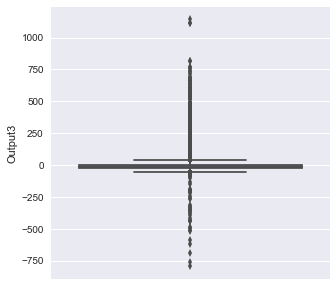

In [10]:
plt.figure(figsize=(5, 5))
sns.boxplot(y='Output3', data=final_df)

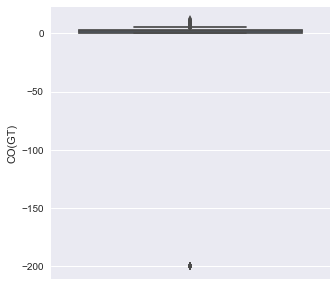

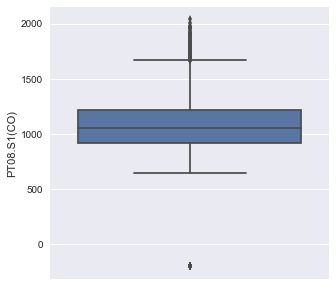

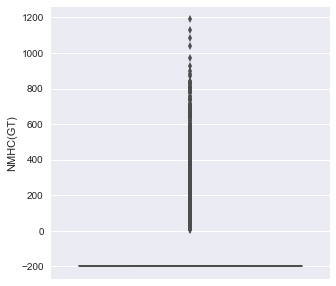

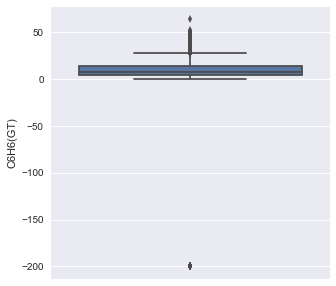

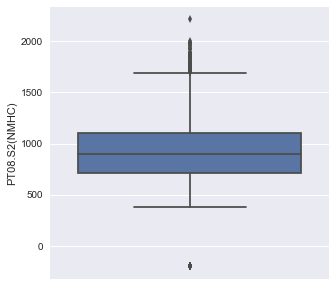

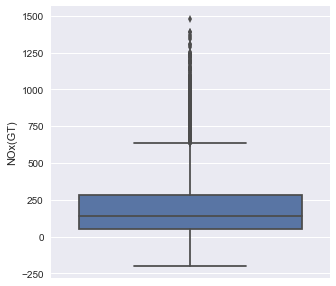

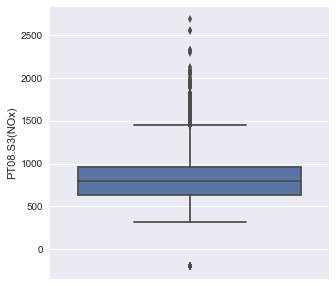

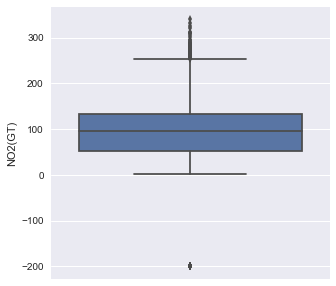

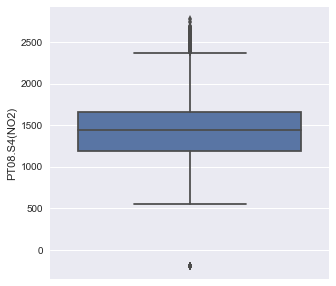

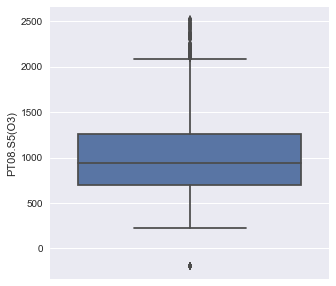

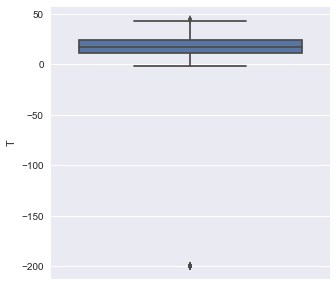

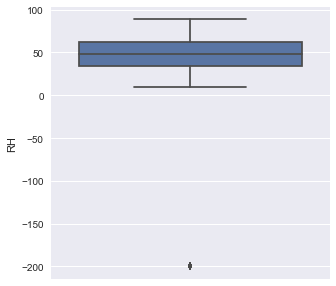

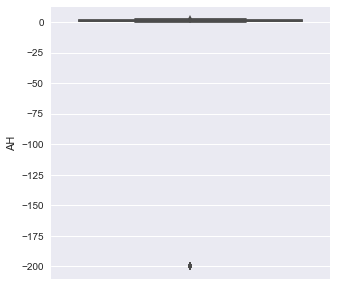

In [11]:
cont_cols = [col for col in final_df.columns if col not in ['Output3']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=col, data=final_df)

c:\users\brsingh\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


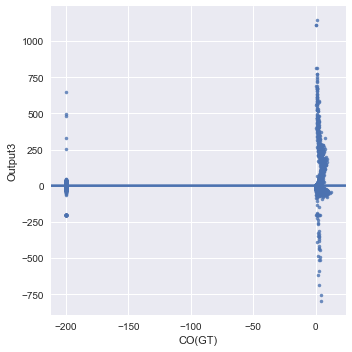

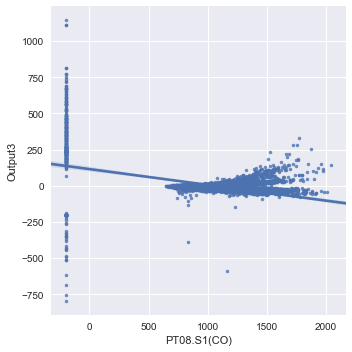

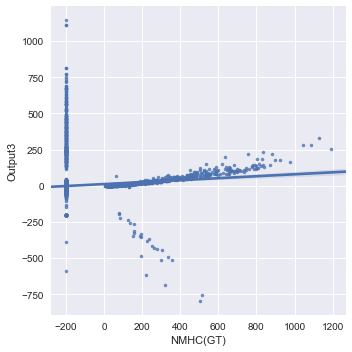

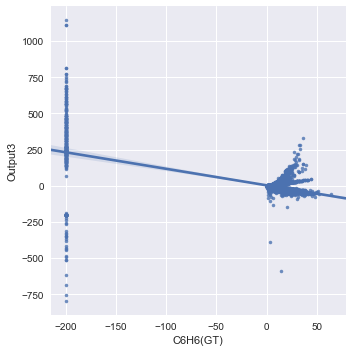

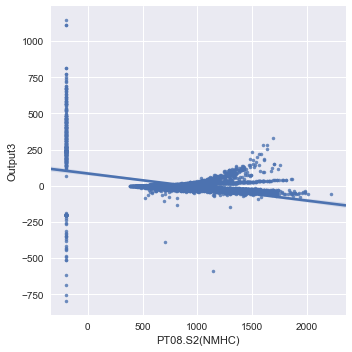

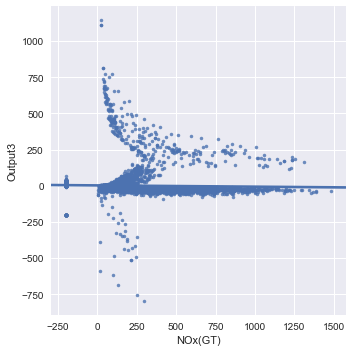

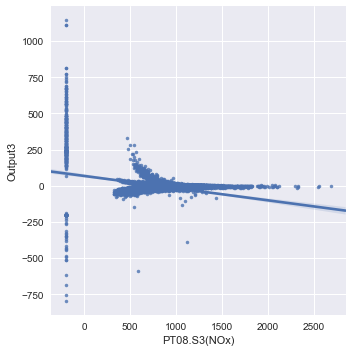

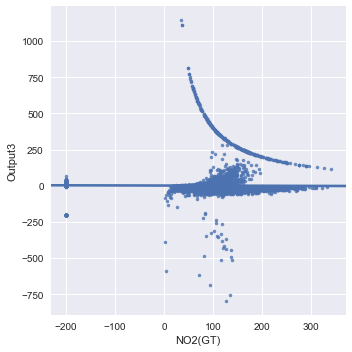

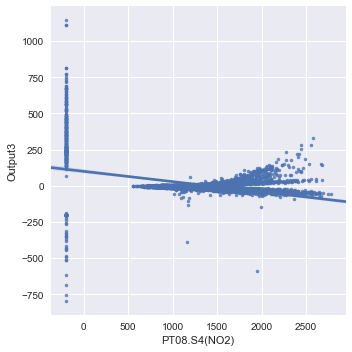

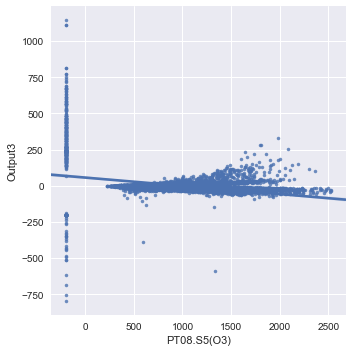

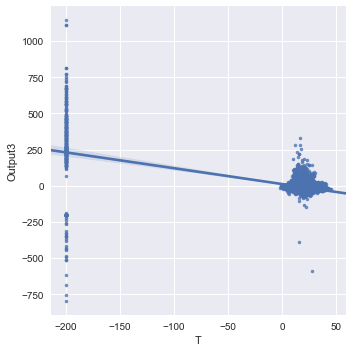

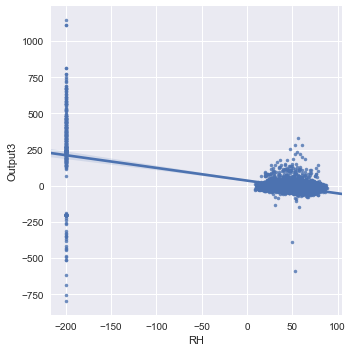

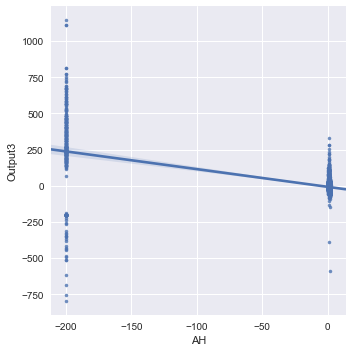

In [12]:
for i in cont_cols:
    sns.lmplot(x=i,y='Output3',data=final_df,markers='.')
    

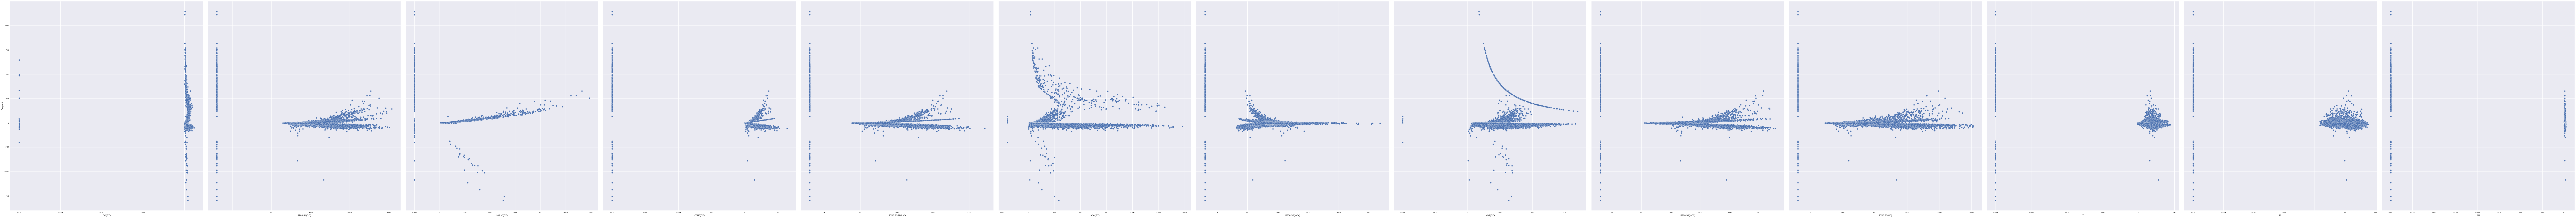

In [13]:
sns.pairplot(final_df, x_vars=cont_cols, y_vars='Output3',size=15, aspect=0.9, kind='scatter')

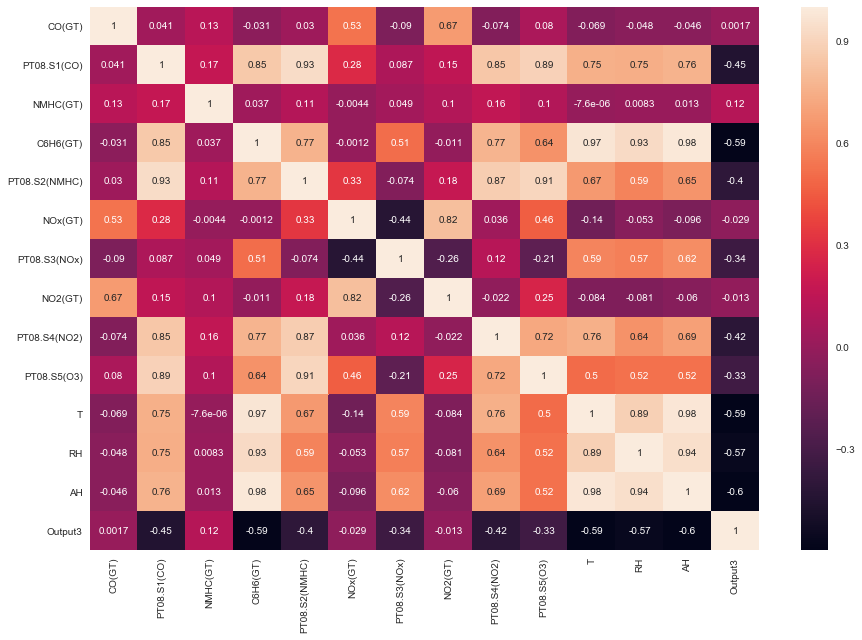

In [14]:
plt.figure(figsize = (15,10))
sns.heatmap(final_df.corr(),annot = True)

In [15]:
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

#defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))

# UDF for feature getting feature variable
def get_feature_variable(df,dependent_var):
    return df.loc[:,df.columns!=dependent_var], df[dependent_var]
                                            
                                              
# applying normalize ( ) to all columns 
# final_df = final_df.apply(normalize)

In [16]:
# Putting feature variable to X
# Putting response variable to y

X,y = get_feature_variable(final_df, 'Output3')

# X_norm = X.apply(normalize)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

In [18]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(6549, 13) (2808, 13) (6549,) (2808,)


## LinearRegression

In [19]:
lrm = LinearRegression()
linear_model = lrm.fit(X_train,y_train)

y_pred_lr=linear_model.predict(X_test)  

print('RMSE of predicted RH in RF model:',np.sqrt(mean_squared_error(y_test,y_pred_lr)))

mse = mean_squared_error(y_test, y_pred_lr)
r_squared = r2_score(y_test, y_pred_lr)
print('Mean_Squared_Error :' ,mse)
print('Model Accuracy r_square_value :',r_squared)

from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lr))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr))) 

RMSE of predicted RH in RF model: 65.91613659794845
Mean_Squared_Error : 4344.9370639993995
Model Accuracy r_square_value : 0.3373171893762499
Mean Absolute Error: 17.432218030228444
Mean Squared Error: 4344.9370639993995
Root Mean Squared Error: 65.91613659794845


Text(0,0.5,'Views')

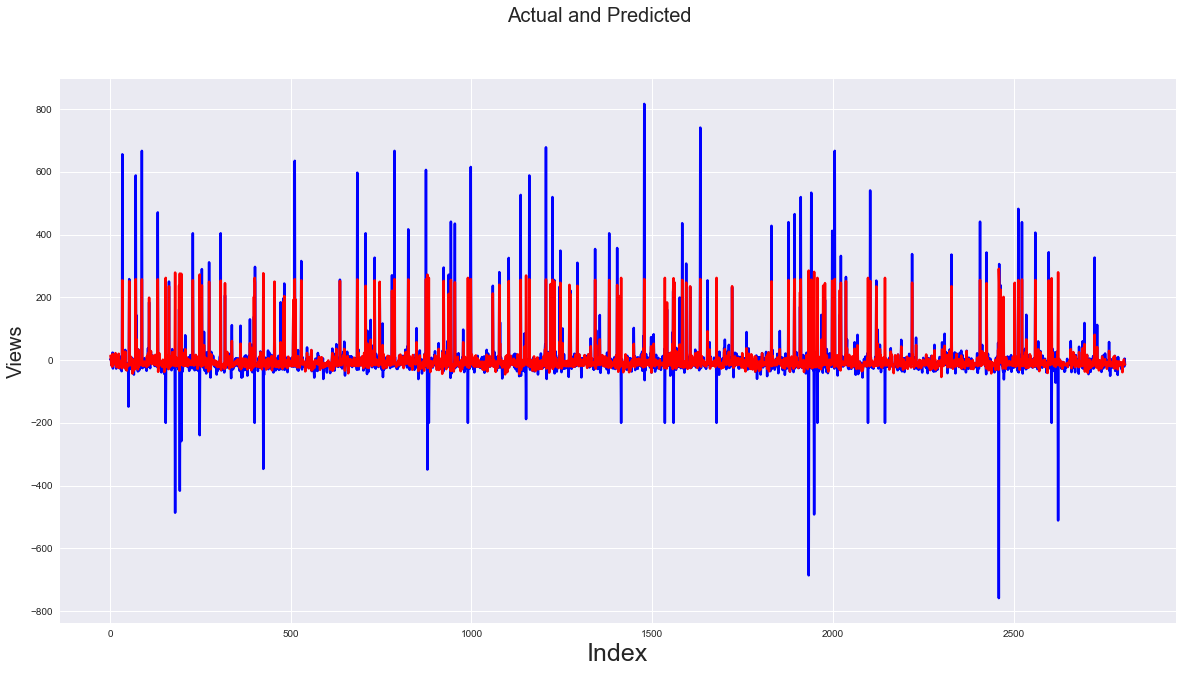

In [20]:
#Actual vs Predicted
# As we can see the model is fiting properly
c = [i for i in range(1,2809,1)]
fig = plt.figure(figsize=(20, 10))
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_pred_lr, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=25)                               # X-label
plt.ylabel('Views', fontsize=20)                               # Y-label

Text(0,0.5,'Views_show-Predicted_views')

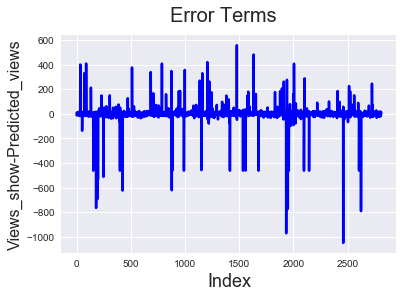

In [21]:
# Error terms
c = [i for i in range(1,2809,1)]
fig = plt.figure()
plt.plot(c,y_test-y_pred_lr, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('Views_show-Predicted_views', fontsize=16)                # Y-label

Text(0,0.5,'y_pred')

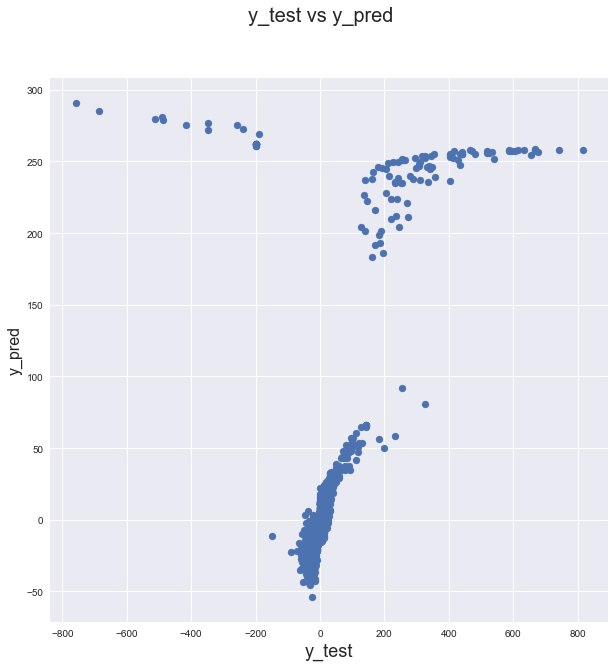

In [22]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test,y_pred_lr)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [23]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_lr})  
df.head(10)

,Actual,Predicted
343,2.254468,13.743879
155,0.441878,7.468679
5337,5.191654,-6.475419
2532,-13.843490,-16.306911
3270,-18.931359,-12.697454
4608,-15.055227,-20.889389
646,23.703787,19.534177
7368,-26.718802,-16.049837
9233,-11.548612,-15.952354
8427,-10.806686,-13.734630


# With OLS model

In [24]:
X_train_1 = sm.add_constant(X_train)
# create a fitted model in one line
ols_model = sm.OLS(y_train,X_train_1).fit()

In [25]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Output3   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     351.5
Date:                Thu, 13 Dec 2018   Prob (F-statistic):               0.00
Time:                        01:50:34   Log-Likelihood:                -36191.
No. Observations:                6549   AIC:                         7.241e+04
Df Residuals:                    6535   BIC:                         7.251e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.3987     19.998      0.220

In [26]:
colVal = X_train.columns
columns=[]
columns.append('const')
columns.extend(list(colVal))

cofficient=[]
x=True
for val in columns:
    cofficient.append(round(pd.Series(ols_model.params).get(val),4))

def newPrint(val, string):
    if val==1:
        return string
    elif val==0:
        return ''
    return '+['+string+'*'+str(val)+']'

def getEquestion(li,col):
    temp="f(x)="
    for v in range(len(col)):
         temp=temp+(newPrint(li[v],col[v]))
    return temp

print('Equestion: ',getEquestion(cofficient,columns))

Equestion:  f(x)=+[const*4.3987]+[CO(GT)*-0.0052]+[PT08.S1(CO)*0.0431]+[NMHC(GT)*0.06]+[C6H6(GT)*1.2023]+[PT08.S2(NMHC)*-0.0308]+[NOx(GT)*-0.0665]+[PT08.S3(NOx)*0.0026]+[NO2(GT)*0.0518]+[PT08.S4(NO2)*-0.0124]+[PT08.S5(O3)*-0.0002]+[T*-0.3551]+[RH*-0.0343]+[AH*-2.1428]


### Polynomial model

In [27]:
# vari = ['NO2(GT)','NMHC(GT)','NOx(GT)','RH','PT08.S3(NOx)','PT08.S4(NO2)','T','AH','RH']
poly = PolynomialFeatures(degree=3)
X_ = poly.fit_transform(X_train)
predict_ = poly.fit_transform(X_test)

clf = LinearRegression()
clf.fit(X_, y_train)
pred=clf.predict(predict_)

In [28]:
print('RMSE of predicted RH in RF model:',np.sqrt(mean_squared_error(y_test,pred)))

mse = mean_squared_error(y_test, pred)
r_squared = r2_score(y_test, pred)
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

poly_df = pd.DataFrame({'Actual':y_test, 'Predicted':pred})
poly_df.head(10)

RMSE of predicted RH in RF model: 21.082645436940798
Mean_Squared_Error : 444.47793861976066
r_square_value : 0.9322089399026484


,Actual,Predicted
343,2.254468,-1.955868
155,0.441878,-5.681137
5337,5.191654,7.526011
2532,-13.843490,-9.003950
3270,-18.931359,-19.815740
4608,-15.055227,-18.585159
646,23.703787,25.216838
7368,-26.718802,-28.356732
9233,-11.548612,-9.883813
8427,-10.806686,10.189065


In [29]:
X_train_poly = sm.add_constant(X_)
# create a fitted model in one line
poly_ols_model = sm.OLS(y_train,X_train_poly).fit()

print(poly_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Output3   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     225.5
Date:                Thu, 13 Dec 2018   Prob (F-statistic):               0.00
Time:                        01:50:35   Log-Likelihood:                -27836.
No. Observations:                6549   AIC:                         5.678e+04
Df Residuals:                    5995   BIC:                         6.054e+04
Df Model:                         553                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.3230   2416.766      0.022      0.9

In [30]:
def _combinations(n_features, degree, interaction_only, include_bias):
        comb = (combinations if interaction_only else combinations_w_r)
        start = int(not include_bias)
        return chain.from_iterable(comb(range(n_features), i)
                                   for i in range(start, degree + 1))
    
combinations = _combinations(13, 3,False,True)
# print(combinations)
val_o = np.vstack([np.bincount(c, minlength=13) for c in combinations])
print(val_o.shape)
print(val_o)

colList=[]
colList.append('const')
for i in range(1,560):    
    colList.append("x"+str(i))

cofficient=[]
x=True
for val in colList:
    cofficient.append(round(poly_ols_model.params.get(val),3))

(560, 13)
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 2 1]
 [0 0 0 ... 0 1 2]
 [0 0 0 ... 0 0 3]]


In [31]:
output = cofficient #[1,2,3,4,5,6,7,8,9,0]
rel=""
cols=colList
val = val_o

def newPrint(val, string):
    if val==1:
        return string
    elif val==0:
        return ''
    return '['+string+'^'+str(val)+']'

for array in range(len(val)):
    if(round(output[array],3)==0):
        continue
    temp="("+str(round(output[array],3))+")*"
    for index in range(len(val[array])):
        temp+=(newPrint(val[array][index],cols[index]))
    rel = rel+" + "+temp
print(print('Equestion:  f(x)=',rel[2:]))

Equestion:  f(x)=  (52.323)* + (11.224)*const + (-0.032)*x1 + (2.406)*x2 + (179.088)*x3 + (-14.473)*x4 + (-3.356)*x5 + (-1.257)*x6 + (-3.7)*x7 + (-4.717)*x8 + (-0.783)*x9 + (41.539)*x10 + (7.638)*x11 + (185.102)*x12 + (3.06)*[const^2] + (0.014)*constx1 + (-0.011)*constx2 + (-7.371)*constx3 + (-0.075)*constx4 + (0.015)*constx5 + (-0.014)*constx6 + (-0.006)*constx7 + (0.005)*constx8 + (-0.009)*constx9 + (-0.423)*constx10 + (-0.184)*constx11 + (5.674)*constx12 + (0.001)*[x1^2] + (-0.002)*x1x2 + (-3.459)*x1x3 + (-0.037)*x1x4 + (0.004)*x1x5 + (0.002)*x1x6 + (-0.009)*x1x7 + (0.001)*x1x8 + (0.036)*x1x10 + (0.019)*x1x11 + (-2.632)*x1x12 + (-1.482)*x2x3 + (-0.016)*x2x4 + (0.001)*x2x5 + (0.002)*x2x6 + (-0.001)*x2x7 + (-0.002)*x2x8 + (-0.046)*x2x10 + (-0.012)*x2x11 + (2.228)*x2x12 + (286.035)*[x3^2] + (20.265)*x3x4 + (1.962)*x3x5 + (-0.469)*x3x6 + (1.248)*x3x7 + (2.084)*x3x8 + (0.018)*x3x9 + (-77.22)*x3x10 + (-28.37)*x3x11 + (1494.12)*x3x12 + (0.22)*[x4^2] + (0.029)*x4x5 + (-0.005)*x4x6 + (0.019)

## With Random Forest

In [32]:
from sklearn.ensemble import RandomForestRegressor           #import random forest regressor
rf_reg=RandomForestRegressor()

rf_model=rf_reg.fit(X_train,y_train)         #fit model   
y_pred_rf=rf_model.predict(X_test)           #predict

print(rf_model.score(X_test,y_test))

c:\users\brsingh\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9814325042745459


In [33]:
print('RMSE of predicted RH in RF model:',np.sqrt(mean_squared_error(y_test,y_pred_rf)))
mse = mean_squared_error(y_test, y_pred_rf)
r_squared = r2_score(y_test, y_pred_rf)
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

RMSE of predicted RH in RF model: 11.033557397531746
Mean_Squared_Error : 121.73938884462753
r_square_value : 0.981432504274546


['CO(GT)' 'PT08.S1(CO)' 'NMHC(GT)' 'C6H6(GT)' 'PT08.S2(NMHC)' 'NOx(GT)'
 'PT08.S3(NOx)' 'NO2(GT)' 'PT08.S4(NO2)' 'PT08.S5(O3)' 'T' 'RH' 'AH']


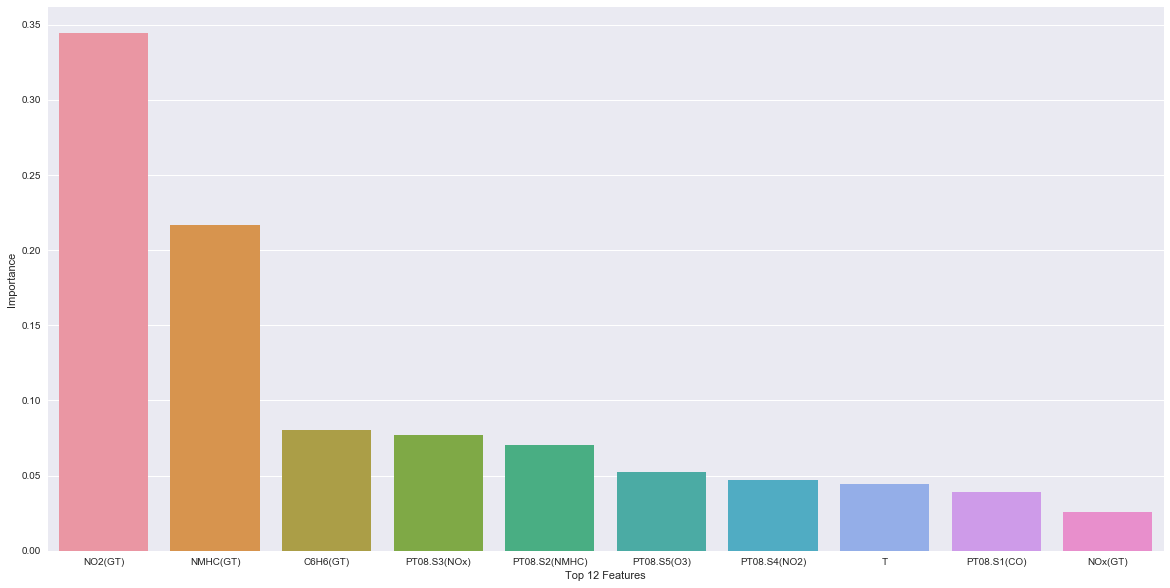

In [34]:

imp=rf_model.feature_importances_
names=X_train.columns.values
print(names)
imp,names=zip(*sorted(zip(imp,names)))

df_1=pd.DataFrame({"Variable":names,"importance":imp})
df_2 = df_1.sort_values(by="importance",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)


plt.figure(figsize=(20, 10))

ax = sns.barplot(x='Variable', y= 'importance', data=df_2[0:10])
ax.set(xlabel = 'Top 12 Features', ylabel = 'Importance')
plt.show()

## Feature Selection with RFE

In [35]:
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [36]:
def get_RFE(independent_data,dependent_data, no_of_variable):
    lm = LinearRegression()
    rfe = RFE(lm, no_of_variable)             # running RFE
    rfe = rfe.fit(independent_data, dependent_data)
    return rfe

In [37]:
#Apply RFE to reduce the Feature
rfe = get_RFE(X_train, y_train, 3)
col_m2 = X_train.columns[rfe.support_]
print('List of Columns After RFE:')
print(list(col_m2))

List of Columns After RFE:
['T', 'RH', 'AH']


In [38]:
# print(col_m2)
col = list(col_m2)
col.append('Output3')
vif_cal(input_data=final_df[col], dependent_col="Output3")

,Var,Vif
0,T,12.56
2,AH,6.87
1,RH,3.80


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X[col_m2], y, train_size=0.7 ,test_size = 0.3, random_state=100)

In [40]:
lrm1 = LinearRegression()
model1 = lrm1.fit(X_train,y_train)

In [41]:
y_pred_lr=model1.predict(X_test)  
print('RMSE of predicted RH in RF model:',np.sqrt(mean_squared_error(y_test,y_pred_lr)))

mse = mean_squared_error(y_test, y_pred_lr)
r_squared = r2_score(y_test, y_pred_lr)
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

RMSE of predicted RH in RF model: 67.17664162981151
Mean_Squared_Error : 4512.701180660126
r_square_value : 0.31173007621143745


Text(0,0.5,'Views')

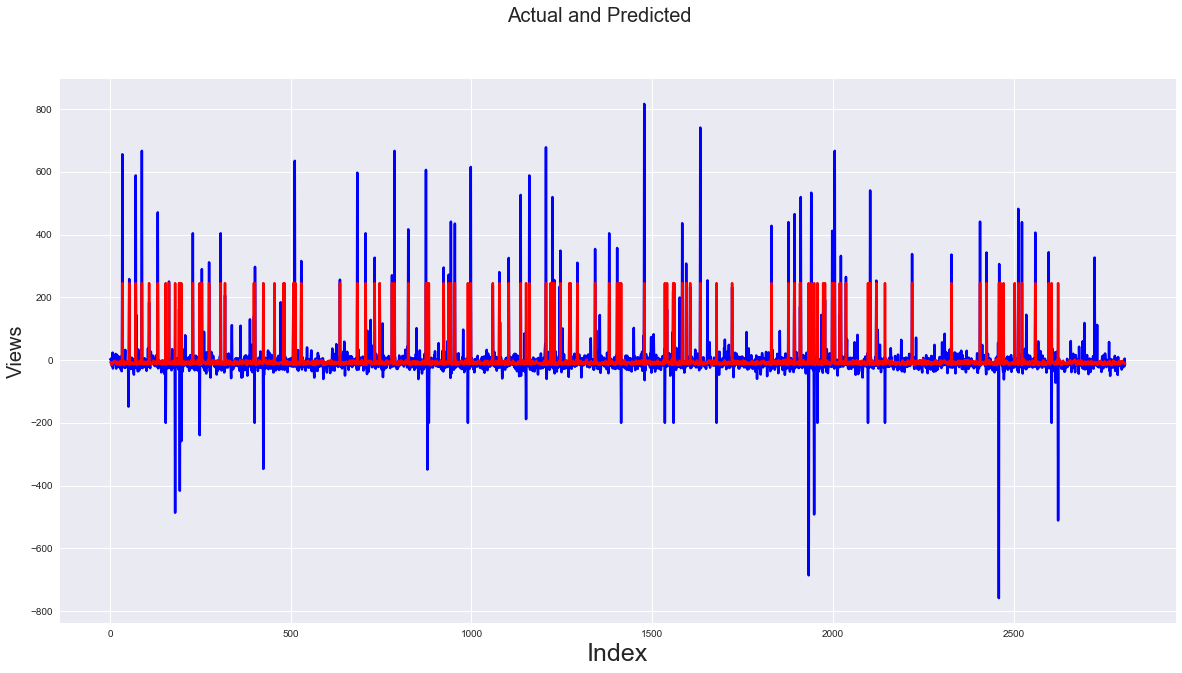

In [42]:
#Actual vs Predicted
# As we can see the model is fiting properly
c = [i for i in range(1,2809,1)]
fig = plt.figure(figsize=(20, 10))
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_pred_lr, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=25)                               # X-label
plt.ylabel('Views', fontsize=20)                               # Y-label

Text(0,0.5,'y_pred')

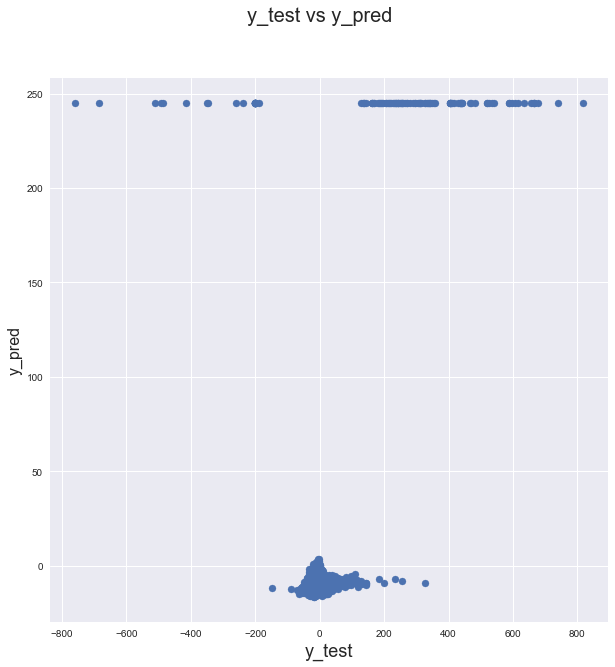

In [43]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test,y_pred_lr)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

## With SVM Model

In [44]:
from sklearn.svm import SVR           #import support vector regressor
sv_reg=SVR(kernel='rbf',gamma='scale')

In [45]:
sv_model=sv_reg.fit(X_train,y_train)

In [46]:
y_pred_sv=sv_model.predict(X_test)  
print('RMSE of predicted RH in RF model:',np.sqrt(mean_squared_error(y_test,y_pred_sv)))

mse = mean_squared_error(y_test, y_pred_sv)
r_squared = r2_score(y_test, y_pred_sv)
print('Mean_Squared_Error :' ,mse)
print('Model Accuracy r_square_value :',r_squared)

RMSE of predicted RH in RF model: 68.58803894322298
Mean_Squared_Error : 4704.319086077073
Model Accuracy r_square_value : 0.28250482156283396
